# Running Sequences and Comparing LSTM vs. GRU


## Part 1: Setting Up the PyTorch Environment


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set a seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.6.0+cu124


## Part 2a: Building LSTM model


In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state (h0) and cell state (c0) with zeros.
        # h0 and c0 shapes: (num_layers, batch_size, hidden_size)
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM forward pass: processes the sequence.
        out, _ = self.lstm(x, (h0, c0))

        # We take the output of the last time step from the sequence (out[:, -1, :])
        # and pass it through a fully connected layer to get the final prediction.
        out = self.fc(out[:, -1, :])
        return out

## Part 2b: Building GRU model


In [ ]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.GRU: The core GRU layer in PyTorch.
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # nn.Linear: A fully connected layer to map the GRU's final hidden state
        # to our desired output size (e.g., a single predicted value).
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state (h0) with zeros.
        # GRUs do not have a separate cell state like LSTMs; their hidden state
        # serves as the primary memory unit.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Ensure h0 is on the same device as x

        # GRU forward pass: processes the input sequence `x`.
        out, _ = self.gru(x, h0)

        # We take the hidden state from the last time step of the last GRU layer.
        last_time_step_output = out[:, -1, :]

        # Pass this through the final fully connected layer to get the prediction.
        out = self.fc(last_time_step_output)
        return out

## Part 3. Data Prep

In [ ]:
# --- Data Preparation for Training ---
# We'll create multiple sine wave sequences for training both models.
seq_len = 50       # Length of the input sequence for training
num_samples = 2000 # Number of sine wave sequences to generate for training

def generate_sine_wave_data(num_samples, seq_len, input_dim):
    X = []
    y = []
    for _ in range(num_samples):
        # Generate a random phase offset for more diverse sine waves
        offset = np.random.rand() * 2 * np.pi
        # Generate a full sequence including the target value
        time_steps = np.linspace(offset, offset + 2 * np.pi, seq_len + 1, dtype=np.float32)
        full_sequence = np.sin(time_steps)

        input_sequence = full_sequence[:-1] # Input: first 'seq_len' points
        target_value = full_sequence[-1]    # Target: the next point

        X.append(input_sequence.reshape(seq_len, input_dim))
        y.append(target_value)
    return np.array(X), np.array(y)

X_train_np, y_train_np = generate_sine_wave_data(num_samples, seq_len, 1)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1) # Reshape target for consistency

print(f"\nTraining Data Shapes:")
print(f"  Input Sequences (X_train): {X_train.shape} (batch_size, seq_len, input_dim)")
print(f"  Target Values (y_train): {y_train.shape} (batch_size, output_dim)")


Training Data Shapes:
  Input Sequences (X_train): torch.Size([2000, 50, 1]) (batch_size, seq_len, input_dim)
  Target Values (y_train): torch.Size([2000, 1]) (batch_size, output_dim)


## Part 4. Running Sequences through Each Model



Running on CPU

--- Training LSTM Model ---
LSTM Epoch [10/50], Loss: 0.0388
LSTM Epoch [20/50], Loss: 0.0121
LSTM Epoch [30/50], Loss: 0.0055
LSTM Epoch [40/50], Loss: 0.0017
LSTM Epoch [50/50], Loss: 0.0004
LSTM Training Complete.

--- Training GRU Model ---
GRU Epoch [10/50], Loss: 0.0192
GRU Epoch [20/50], Loss: 0.0087
GRU Epoch [30/50], Loss: 0.0013
GRU Epoch [40/50], Loss: 0.0001
GRU Epoch [50/50], Loss: 0.0002
GRU Training Complete.


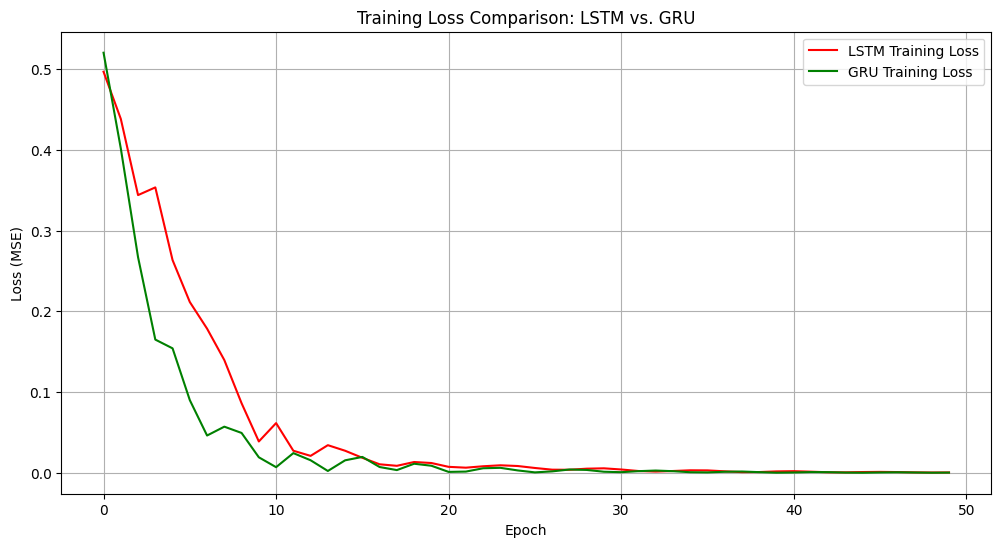

In [ ]:
# Model parameters
input_dim = 1
hidden_dim = 50 # Increased for better learning
layer_dim = 2   # Increased layers for potentially better performance
output_dim = 1

# Instantiate models
lstm_model = SimpleLSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, output_size=output_dim)
gru_model = SimpleGRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, output_size=output_dim)

# --- Device Configuration ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\nRunning on GPU")
else:
    device = torch.device("cpu")
    print("\nRunning on CPU")

# Move models and data to the selected device
lstm_model.to(device)
gru_model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

# --- Training Parameters ---
num_epochs = 50 # Increased epochs for better training
learning_rate = 0.01
criterion = nn.MSELoss() # Mean Squared Error for regression

# --- Training LSTM Model ---
print("\n--- Training LSTM Model ---")
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
lstm_loss_history = []

for epoch in range(num_epochs):
    lstm_model.train()
    optimizer_lstm.zero_grad()
    predictions = lstm_model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer_lstm.step()
    lstm_loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("LSTM Training Complete.")

# --- Training GRU Model ---
print("\n--- Training GRU Model ---")
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
gru_loss_history = []

for epoch in range(num_epochs):
    gru_model.train()
    optimizer_gru.zero_grad()
    predictions = gru_model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer_gru.step()
    gru_loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'GRU Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("GRU Training Complete.")

# --- Plotting Training Loss ---
plt.figure(figsize=(12, 6))
plt.plot(lstm_loss_history, label='LSTM Training Loss', color='red')
plt.plot(gru_loss_history, label='GRU Training Loss', color='green')
plt.title('Training Loss Comparison: LSTM vs. GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Part 5. Evaluation and Analysis


In [ ]:
# --- Evaluation with a New Sine Wave Sequence (After Training) ---
# Generate a single new sine wave sequence for demonstration
eval_seq_len = seq_len
eval_time_steps = np.linspace(0, 4 * np.pi, eval_seq_len + 1, dtype=np.float32) # Extend for next value
eval_full_sequence = np.sin(eval_time_steps)
eval_input_sequence = eval_full_sequence[:-1] # Input sequence for the models
eval_true_next_value = eval_full_sequence[-1] # The actual next value

# Reshape and move to device
eval_input_tensor = torch.tensor(eval_input_sequence.reshape(1, eval_seq_len, input_dim), dtype=torch.float32).to(device)

# Get predictions from trained models
lstm_model.eval() # Set to evaluation mode
gru_model.eval()
with torch.no_grad(): # Disable gradient calculation for inference
    lstm_predicted_value = lstm_model(eval_input_tensor).item()
    gru_predicted_value = gru_model(eval_input_tensor).item()

print(f"\n--- Prediction Results (After Training) ---")
print(f"True next value in sequence: {eval_true_next_value:.4f}")
print(f"LSTM Predicted next value: {lstm_predicted_value:.4f}")
print(f"GRU Predicted next value: {gru_predicted_value:.4f}")


--- Prediction Results (After Training) ---
True next value in sequence: 0.0000
LSTM Predicted next value: -0.1211
GRU Predicted next value: -0.0141


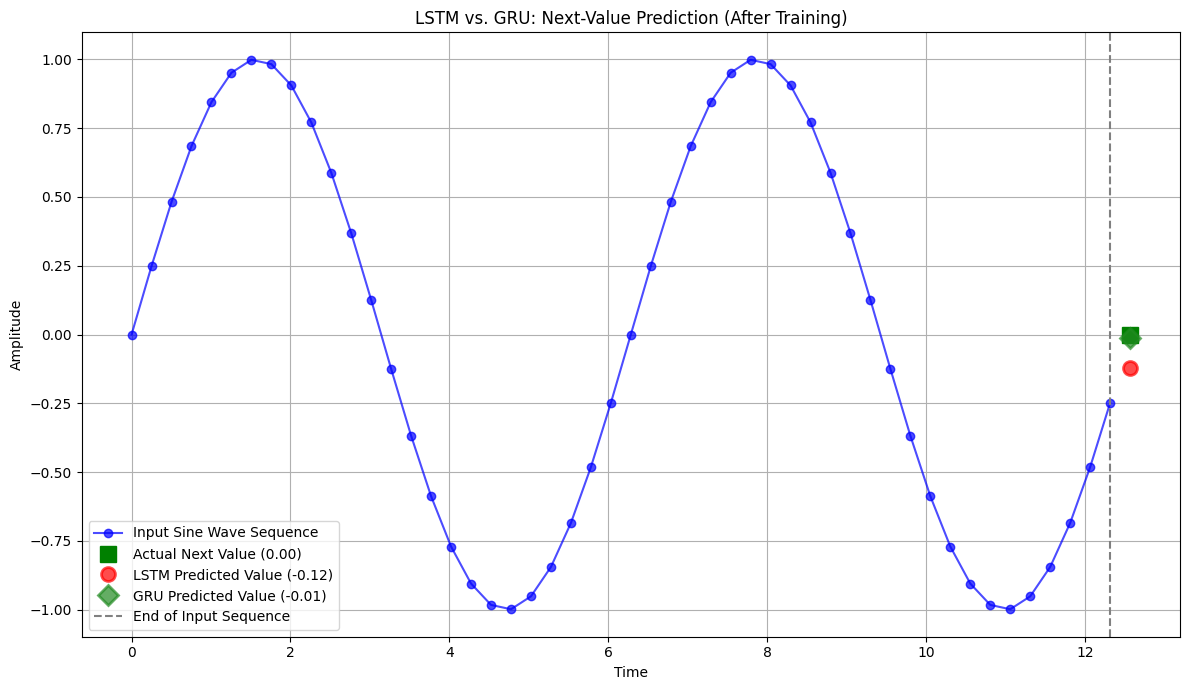

In [ ]:
# --- Visualization of Trained Model Predictions ---
plt.figure(figsize=(12, 7))
# Plot the original input sequence
plt.plot(eval_time_steps[:-1], eval_input_sequence, 'bo-', label='Input Sine Wave Sequence', alpha=0.7)

# Plot the true next value
plt.plot(eval_time_steps[-1], eval_true_next_value, 'gs', markersize=12, label=f'Actual Next Value ({eval_true_next_value:.2f})') # Green Square

# Plot the LSTM's predicted next value
plt.plot(eval_time_steps[-1], lstm_predicted_value, 'ro', markersize=10, markeredgewidth=2, label=f'LSTM Predicted Value ({lstm_predicted_value:.2f})', alpha=0.7) # Red Circle

# Plot the GRU's predicted next value - Using a different green ('forestgreen') and a different marker ('D' for diamond)
plt.plot(eval_time_steps[-1], gru_predicted_value, 'D', markersize=10, markeredgewidth=2, label=f'GRU Predicted Value ({gru_predicted_value:.2f})', color='forestgreen', alpha=0.7) # Green Diamond

plt.title('LSTM vs. GRU: Next-Value Prediction (After Training)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.axvline(eval_time_steps[-2], color='gray', linestyle='--', label='End of Input Sequence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

## LSTM vs. GRU: A Quick Comparison

While both LSTMs and GRUs are powerful **recurrent neural networks** designed to handle **sequential data** and address the **vanishing gradient problem**, they differ in their internal complexity and memory mechanisms.


Ultimately, the choice between LSTM and GRU often comes down to **empirical testing** for your specific dataset and problem.